# CH07 합성곱 신경망 (CNN)

## 파일 설명
| 파일명 | 파일 용도 | 관련 절 | 페이지 |
|:--   |:--      |:--    |:--      |
| apply_filter.py | lena_gray.png 파일에 필터를 적용합니다. |  |  |
| gradient_check.py | SimpleCovNet이 기울기를 올바로 계산하는지 확인합니다. |  |  |
| params.pkl | 미리 학습된 가중치 값들입니다. |  |  |
| simple_convnet.py | “Convolution-ReLU-Pooling-Affine-ReLU-Affine-Softmax” 순으로 흐르는 단순한 합성곱 신경망(CNN)입니다. | 7.5 CNN 구현하기 | 251 |
| train_convnet.py | SimpleConvNet으로 MNIST 데이터셋을 학습합니다. | 7.5 CNN 구현하기 | 254 |
| visualize_filter.py | 합성곱 1번째 층의 가중치를 학습 전과 후로 나눠 시각화해봅니다. 이미 학습된 가중치 값(params.pkl)을 읽어서 사용하므로 학습 과정은 생략됩니다. | 7.6.1 1번째 층의 가중치 시각화하기 | 254 |

## 7장 합성곱 신경망(CNN)
이번 장의 주제는 합성곱 신경망(convolutional neural network, CNN)입니다. CNN은 이미지 인식과 음성 인식 등 다양한 곳에서 사용되는데, 특히 이미지 인식 분야에서 딥러닝을 활용한 기법은 거의 다 CNN을 기초로 하죠. 이번 장에서는 CNN의 메커니즘을 자세히 설명하고 이를 파이썬으로 구현해보겠습니다.

*옮긴이_ 합성곱은 공학과 물리학에서 널리 쓰이는 수학적 개념으로, 간단히 정의해보면 다음과 같습니다.
“두 함수 중 하나를 반전(reverse), 이동(shift)시켜가며 나머지 함수와의 곱을 연이어 적분한다.”
합성곱 신경망을 영어 발음 그대로 ‘컨벌루션 신경망’으로도 많이 씁니다만, 위 정의와 이번 장에서 설명할 동작 원리를 이해하고 나면 ‘합성곱 신경망’이란 용어가 더 직관적으로 다가올 수도 있을 겁니다.*

## 목차
```
7.1 전체 구조 
7.2 합성곱 계층 
__7.2.1 완전연결 계층의 문제점 
__7.2.2 합성곱 연산 
__7.2.3 패딩 
__7.2.4 스트라이드 
__7.2.5 3차원 데이터의 합성곱 연산 
__7.2.6 블록으로 생각하기 
__7.2.7 배치 처리 
7.3 풀링 계층 
__7.3.1 풀링 계층의 특징 
7.4 합성곱/풀링 계층 구현하기 
__7.4.1 4차원 배열 
__7.4.2 im2col로 데이터 전개하기 
__7.4.3 합성곱 계층 구현하기 
__7.4.4 풀링 계층 구현하기 
7.5 CNN 구현하기 
7.6 CNN 시각화하기 
__7.6.1 1번째 층의 가중치 시각화하기 
__7.6.2 층 깊이에 따른 추출 정보 변화 
7.7 대표적인 CNN 
__7.7.1 LeNet 
__7.7.2 AlexNet 
```

## 이번 장에서 배운 내용
* CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가한다.
* 합성곱 계층과 풀링 계층은 im2col (이미지를 행렬로 전개하는 함수)을 이용하면 간단하고 효율적으로 구현할 수 있다.
* CNN을 시각화해보면 계층이 깊어질수록 고급 정보가 추출되는 모습을 확인할 수 있다.
* 대표적인 CNN에는 LeNet과 AlexNet이 있다.
* 딥러닝의 발전에는 빅 데이터와 GPU가 크게 기여했다.


In [17]:
import numpy as np

import sys, os
sys.path.append(os.pardir)

import pickle
from collections import OrderedDict

import matplotlib.pyplot as plt

## 7.4 합성곱/풀링 계층 구현하기

In [7]:
np.random.seed(0)

x = np.random.rand(10, 1, 28, 28) # 높이 28, 너비 28, 채널 1개, 데이터 10개
display(x.shape)
display(x[0, 0]) # 첫번째 데이터의 첫 채널의 공간 데이터

(10, 1, 28, 28)

array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ,
        0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152,
        0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606,
        0.0871293 , 0.0202184 , 0.83261985, 0.77815675, 0.87001215,
        0.97861834, 0.79915856, 0.46147936, 0.78052918, 0.11827443,
        0.63992102, 0.14335329, 0.94466892],
       [0.52184832, 0.41466194, 0.26455561, 0.77423369, 0.45615033,
        0.56843395, 0.0187898 , 0.6176355 , 0.61209572, 0.616934  ,
        0.94374808, 0.6818203 , 0.3595079 , 0.43703195, 0.6976312 ,
        0.06022547, 0.66676672, 0.67063787, 0.21038256, 0.1289263 ,
        0.31542835, 0.36371077, 0.57019677, 0.43860151, 0.98837384,
        0.10204481, 0.20887676, 0.16130952],
       [0.65310833, 0.2532916 , 0.46631077, 0.24442559, 0.15896958,
        0.11037514, 0.65632959, 0.13818295, 0.19658236, 0.36872517,
        0.82099323, 0.09710128, 0.83794491, 0.09609841, 0.97645947,
        0.4686512 , 0.9767

### 7.4.2 im2col로 데이터 전개하기

In [23]:
# common/util.py

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

In [10]:
x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)

x2 = np.random.rand(10, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)

(9, 75)
(90, 75)


In [11]:
# 합성곱 계층 구현: common.layers.py

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [12]:
# 풀링 계층 구현하기: common/layers.py

class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## 7.5 CNN 구현하기

In [15]:
# ch07/simple_convnet.py

from src.common.gradient import numerical_gradient

class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

### SimpleNet으로 MNIST 데이터셋 학습

train loss:2.2995566840985933
=== epoch:1, train acc:0.132, test acc:0.145 ===
train loss:2.297908807243491
train loss:2.2939922540397273
train loss:2.288061046314952
train loss:2.278024085624977
train loss:2.266714798190005
train loss:2.2637797922543452
train loss:2.235382244407729
train loss:2.207015492268314
train loss:2.2028362483781563
train loss:2.183082514364516
train loss:2.153369697191434
train loss:2.108686218693852
train loss:2.007267649709703
train loss:2.0232236188334682
train loss:1.961979461408567
train loss:1.8945062217073192
train loss:1.781074928354131
train loss:1.6910554027195954
train loss:1.5658614364162113
train loss:1.5381739006064954
train loss:1.5282891571001627
train loss:1.3227602529628388
train loss:1.3697570816049096
train loss:1.182368655855534
train loss:1.1362564500858423
train loss:1.1974196853725905
train loss:1.1119998566052036
train loss:1.0353910345113149
train loss:0.9346453202063159
train loss:0.9750670991993208
train loss:0.8055751629547637
trai

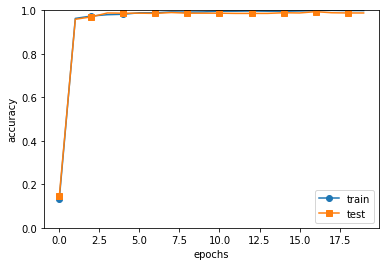

In [24]:
# ch07/train_convnet.py
from src.dataset.mnist import load_mnist
from src.common.layers import Relu, Affine, SoftmaxWithLoss
from src.common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

* 학습에 대략 30분 정도 걸린듯...

## 7.6 CNN 시각화 하기

### 7.6.1 1번째 층의 가중치 시각화하기

무작위(랜덤) 초기화 후의 가중치


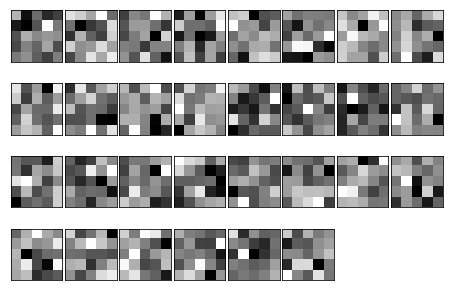

학습된 가중치


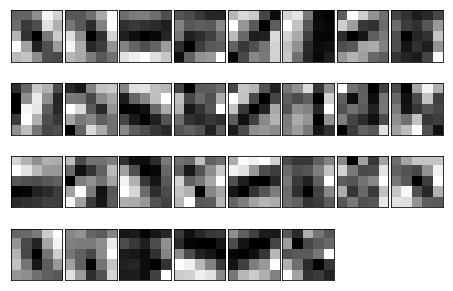

In [26]:
# ch07/visualize_filter.py

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
print("무작위(랜덤) 초기화 후의 가중치")
filter_show(network.params['W1'])

# 학습된 가중치
print("학습된 가중치")
network.load_params("params.pkl")
filter_show(network.params['W1'])